In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,models
from sklearn.metrics import classification_report
import os
import seaborn as sns 
from sklearn.metrics import confusion_matrix

In [3]:
# read the csv file to check out the images and class
data = pd.read_csv('/Users/abiolaayuba/Downloads/data/train.csv')
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [4]:
data['Class'].replace(['YOUNG','MIDDLE','OLD'],[0,1,2],inplace=True)
data.head(3)

,ID,Class
0,377.jpg,1
1,17814.jpg,0
2,21283.jpg,1


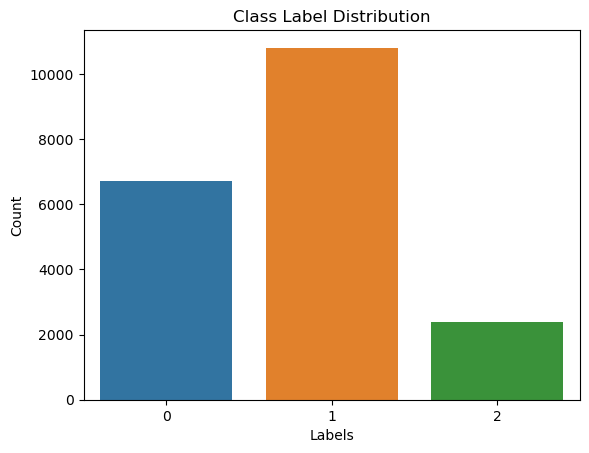

In [5]:
sns.countplot(x='Class', data=data)  # Assuming 'Class' is the column containing labels
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Class Label Distribution')
plt.show()

In [9]:
def readImage(path,ch = 3, resize=(150,150)):
	di = tf.io.read_file(path)
	di = tf.image.decode_jpeg(di, channels=ch)
	di = tf.image.convert_image_dtype(di, dtype=tf.float32)
	di = tf.image.resize(di, resize)
	return di

In [6]:
# function to load the data that includes images and respective labels
def load_data(image_path, label):
    img = readImage(image_path, 3, (150,150))
    return (img, label)

In [7]:
# built the list of image paths and list of respective responses of the images
PATH = '/Users/abiolaayuba/Downloads/data/Train'
image_paths = []
for path in os.listdir(PATH):
    image_paths.append(PATH+"/"+path)
print(len(image_paths))

response_list = []

for i in image_paths:
    _,tail = os.path.split(i)
    response = data.loc[data['ID'] == tail]['Class'].values[0]
    response_list.append(response)
print(len(response_list))

19906
19906


In [22]:
#To inspect the shape of the images return by the above function
for image_path in range(5):
    img = readImage(image_paths[image_path], 3, (150, 150))
    print(img.shape, img.dtype)

(150, 150, 3) <dtype: 'float32'>
(150, 150, 3) <dtype: 'float32'>
(150, 150, 3) <dtype: 'float32'>
(150, 150, 3) <dtype: 'float32'>
(150, 150, 3) <dtype: 'float32'>


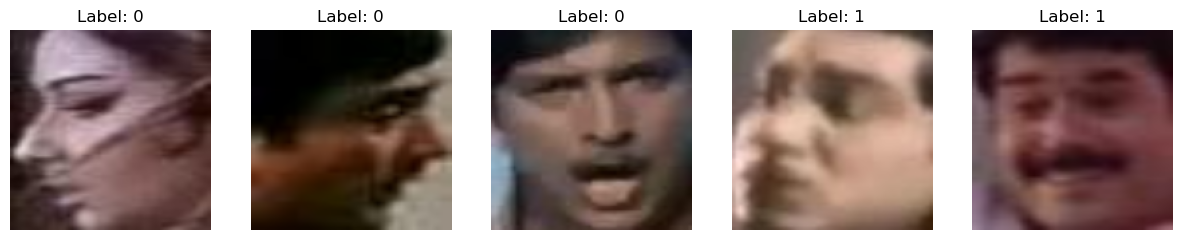

In [11]:
# To display a number of images from the image file
num_images_to_display = 5

# To create a single row subplot
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for idx, (img_path, label) in enumerate(zip(image_paths[:num_images_to_display], response_list[:num_images_to_display])):
    img = readImage(img_path, 3, (150, 150))

    # Display the image in the corresponding subplot
    axes[idx].imshow(img.numpy())
    axes[idx].set_title(f"Label: {label}")
    axes[idx].axis('off')

plt.show()

In [58]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

def augment_images(image_paths):
    augmented_images = []

    # Create an ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for image_path in image_paths:
        # Load the original image
        original_image = Image.open(image_path)

        # Convert the image to a numpy array
        image_array = np.array(original_image)

        # Reshape the image array to (1, height, width, channels)
        image_array = image_array.reshape((1,) + image_array.shape)

        # Generate augmented images
        augmented_images_batch = []
        for batch in datagen.flow(image_array, batch_size=1, seed=42):
            augmented_images_batch.append(batch)
            break  # Break the loop to avoid an infinite loop of image generation

        # Reshape augmented images back to the original shape
        augmented_images_batch = np.array(augmented_images_batch[0]).astype('uint8')
        augmented_images.append(augmented_images_batch[0])

    return augmented_images

augmented_img = augment_images(image_paths)

In [59]:
print(len(augmented_img))

19906


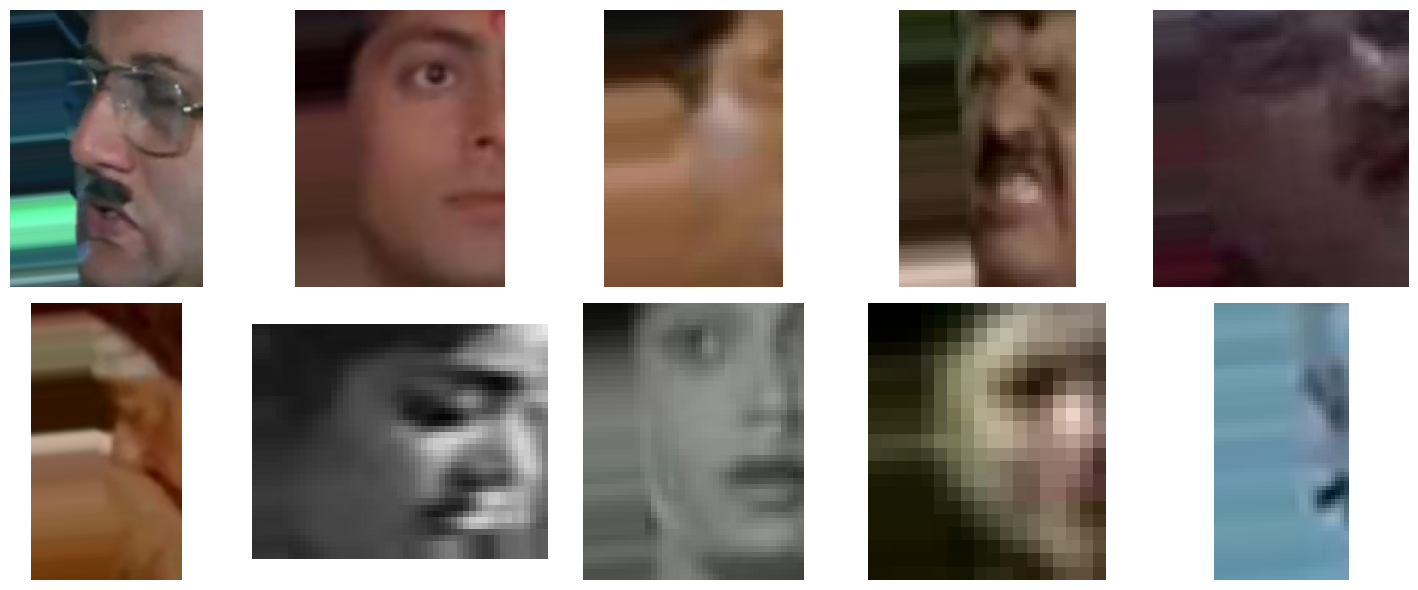

In [60]:
import matplotlib.pyplot as plt
import numpy as np

random_indices = np.random.choice(len(augmented_img), 10, replace=False)

plt.figure(figsize=(15, 6))  
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)  
    plt.imshow(augmented_img[idx])  
    plt.axis('off')
plt.tight_layout()  
plt.show() 

In [23]:

# split the dataset into train and test dataset
train_size = int(0.8*(len(image_paths)))
print(train_size)
test_size = int(0.2*(len(image_paths)))

train_set = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], response_list[:train_size]))
test_set = tf.data.Dataset.from_tensor_slices((image_paths[test_size:], response_list[test_size:]))

15924


In [25]:
for i in range(2):
    print(type(image_paths[i]))
    print(type(response_list[i]))

<class 'str'>
<class 'numpy.int64'>
<class 'str'>
<class 'numpy.int64'>


In [26]:

train_set = (train_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [27]:

test_set = (test_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [64]:

# split the dataset into train and test dataset
augment_train_size = int(0.8*(len(augmented_img)))
print(train_size)
augment_test_size = int(0.2*(len(augmented_img)))

augmented_train_set = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], response_list[:train_size]))
augmented_test_set = tf.data.Dataset.from_tensor_slices((image_paths[test_size:], response_list[test_size:]))

15924


In [65]:

augmented_train_set = (augmented_train_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [66]:
augmented_test_set = (augmented_test_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [28]:
# build the layers of CNN model

model = models.Sequential([
    layers.Conv2D(filters=30, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(3, activation='softmax')
])

In [52]:
# view the summary of the cnn model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 30)      840       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 30)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        17344     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 64)                5

In [30]:
# compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# fit the model
history = model.fit(train_set, epochs=15, validation_data=test_set)

Epoch 1/15
249/249 [==============================] - 229s 917ms/step - loss: 0.8813 - accuracy: 0.6110 - val_loss: 0.7508 - val_accuracy: 0.6695
Epoch 2/15
249/249 [==============================] - 221s 887ms/step - loss: 0.7583 - accuracy: 0.6651 - val_loss: 0.7046 - val_accuracy: 0.6907
Epoch 3/15
249/249 [==============================] - 216s 867ms/step - loss: 0.7035 - accuracy: 0.6902 - val_loss: 0.6691 - val_accuracy: 0.6948
Epoch 4/15
249/249 [==============================] - 229s 919ms/step - loss: 0.6631 - accuracy: 0.7067 - val_loss: 0.6303 - val_accuracy: 0.7214
Epoch 5/15
249/249 [==============================] - 211s 848ms/step - loss: 0.6245 - accuracy: 0.7300 - val_loss: 0.6040 - val_accuracy: 0.7380
Epoch 6/15
249/249 [==============================] - 215s 863ms/step - loss: 0.5801 - accuracy: 0.7466 - val_loss: 0.5545 - val_accuracy: 0.7707
Epoch 7/15
249/249 [==============================] - 216s 867ms/step - loss: 0.5379 - accuracy: 0.7725 - val_loss: 0.5317 -

In [67]:

# build the layers of CNN model

aug_model = models.Sequential([
    layers.Conv2D(filters=30, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(3, activation='softmax')
])

# compile the model
aug_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [68]:
# fit the model
augmented_history = aug_model.fit(augmented_train_set, epochs=15, validation_data=augmented_test_set)

Epoch 1/15
249/249 [==============================] - 212s 849ms/step - loss: 0.9088 - accuracy: 0.5885 - val_loss: 0.7932 - val_accuracy: 0.6316
Epoch 2/15
249/249 [==============================] - 246s 991ms/step - loss: 0.7787 - accuracy: 0.6549 - val_loss: 0.7282 - val_accuracy: 0.6794
Epoch 3/15
249/249 [==============================] - 203s 817ms/step - loss: 0.7392 - accuracy: 0.6707 - val_loss: 0.6846 - val_accuracy: 0.7002
Epoch 4/15
249/249 [==============================] - 219s 876ms/step - loss: 0.7002 - accuracy: 0.6872 - val_loss: 0.6480 - val_accuracy: 0.7186
Epoch 5/15
249/249 [==============================] - 212s 852ms/step - loss: 0.6638 - accuracy: 0.7047 - val_loss: 0.6369 - val_accuracy: 0.7258
Epoch 6/15
249/249 [==============================] - 232s 931ms/step - loss: 0.6243 - accuracy: 0.7263 - val_loss: 0.5865 - val_accuracy: 0.7532
Epoch 7/15
249/249 [==============================] - 218s 877ms/step - loss: 0.5851 - accuracy: 0.7427 - val_loss: 0.5510 -

In [70]:
# test accuracy
model.evaluate(test_set)

249/249 [==============================] - 57s 229ms/step - loss: 0.4850 - accuracy: 0.8529


[0.4850109815597534, 0.8528728485107422]

In [71]:
# test accuracy
aug_model.evaluate(augmented_test_set)

249/249 [==============================] - 55s 220ms/step - loss: 0.4765 - accuracy: 0.8278


[0.47646060585975647, 0.8278179168701172]

In [58]:
model.save("model.h5")

/Users/abiolaayuba/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


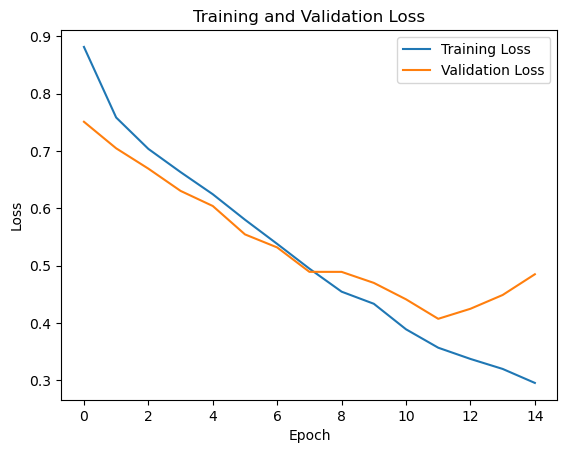

In [72]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


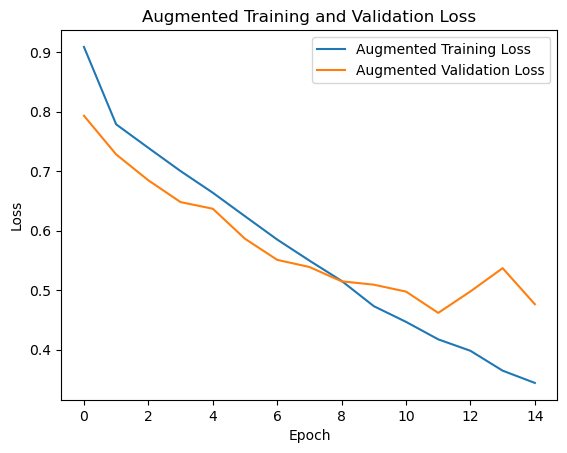

In [73]:
# Plot training and validation loss
plt.plot(augmented_history.history['loss'], label='Augmented Training Loss')
plt.plot(augmented_history.history['val_loss'], label='Augmented Validation Loss')
plt.title('Augmented Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


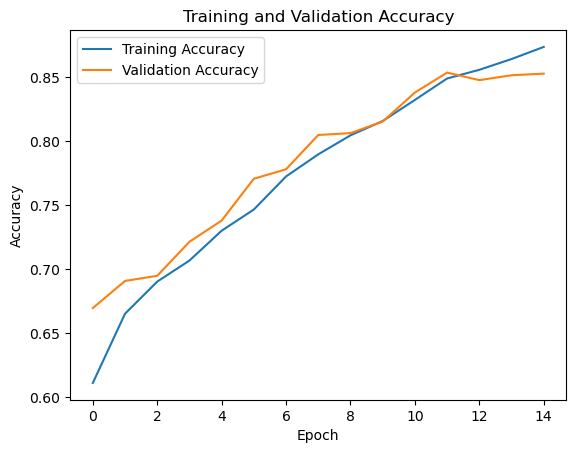

In [74]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


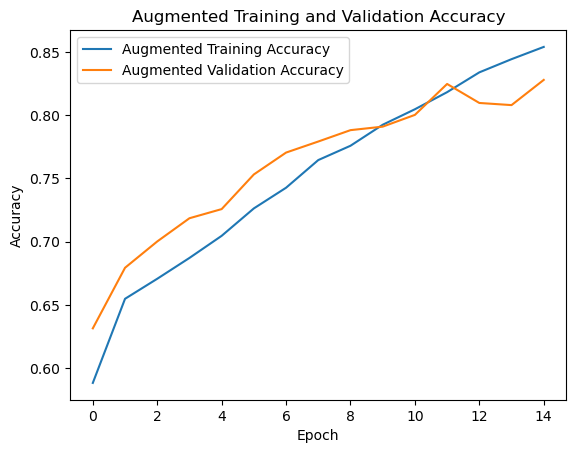

In [75]:
# Plot training and validation accuracy
plt.plot(augmented_history.history['accuracy'], label='Augmented Training Accuracy')
plt.plot(augmented_history.history['val_accuracy'], label='Augmented Validation Accuracy')
plt.title('Augmented Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [76]:
def generate_classification_report(test_response, y_labels, class_names):
    report = classification_report(test_response, y_labels, target_names=class_names)
    print("Classification Report:\n", report)

test_pred = aug_model.predict(test_set)
y_labels = [np.argmax(item) for item in test_pred]
test_response = response_list[test_size:]
class_names = ['YOUNG', 'MIDDLE', 'OLD']

# To generate and print the classification report
generate_classification_report(test_response, y_labels, class_names)


249/249 [==============================] - 59s 238ms/step
Classification Report:
               precision    recall  f1-score   support

       YOUNG       0.84      0.82      0.83      5386
      MIDDLE       0.82      0.91      0.86      8620
         OLD       0.89      0.49      0.63      1919

    accuracy                           0.83     15925
   macro avg       0.85      0.74      0.77     15925
weighted avg       0.83      0.83      0.82     15925



In [77]:
test_pred = aug_model.predict(test_set)

249/249 [==============================] - 54s 217ms/step


In [79]:
y_labels = [np.argmax(item) for item in test_pred]
print("Test Predictions response sample:",y_labels[:10])

test_response = response_list[test_size:]
print("Test True response sample:", test_response[:10])


Test Predictions response sample: [0, 1, 1, 1, 0, 0, 1, 0, 1, 1]
Test True response sample: [0, 1, 1, 1, 0, 1, 0, 1, 1, 1]


In [81]:
# funtion to plot confusion matrix to check the accuracy of each class value
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

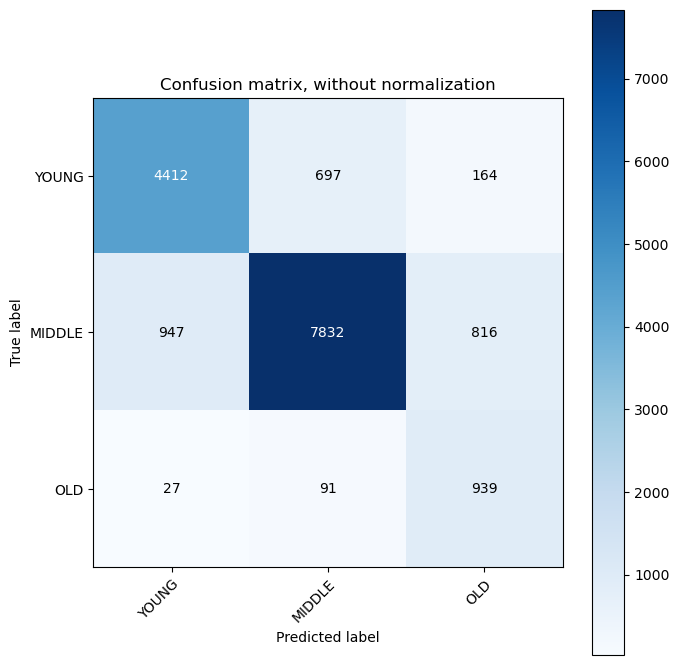

In [84]:
# plotting confusion matrix without normalization
plot_confusion_matrix(y_labels,test_response, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

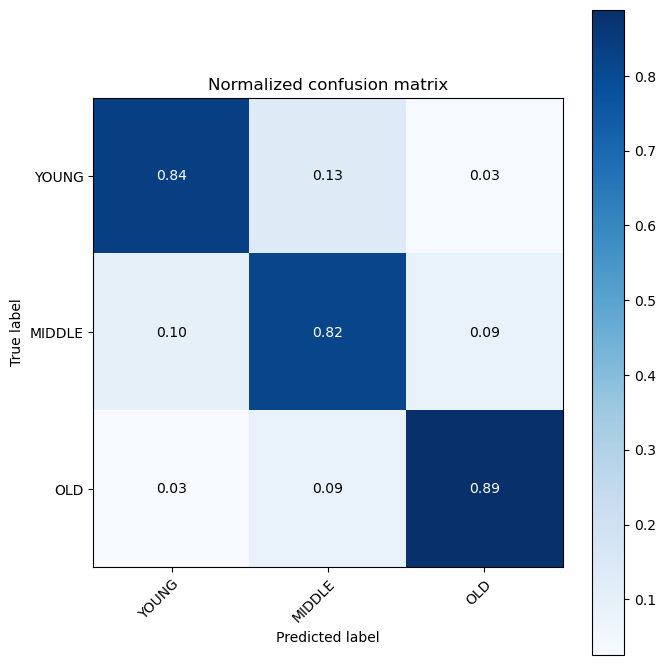

In [85]:
# plotting confusion matrix with normalization
plot_confusion_matrix(y_labels, test_response, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

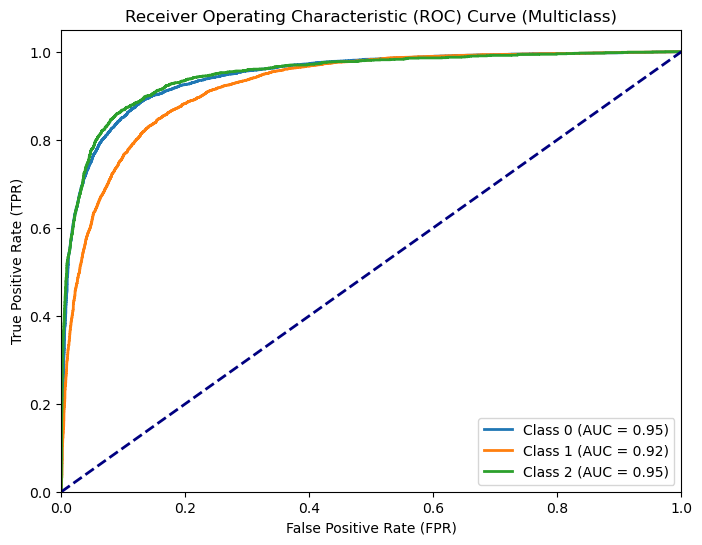

In [86]:
# Extracting true labels from the test set
y_true = np.concatenate([y for x, y in test_set], axis=0)

# Make predictions on the test set
y_scores = test_pred  

# Binarize the labels (one-vs-all strategy)
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Calculate ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_true_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(y_true_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (Multiclass)')
plt.legend(loc="lower right")
plt.show()


In [88]:
!pip install anvil-uplink


  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [89]:
import anvil.server

anvil.server.connect("server_VLDX33BZY5DD4KR6S4LMLUKG-7PIZ3AKSD4KP2TC2")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [91]:
import anvil.media
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

@anvil.server.callable

def classify_image(file):
    with anvil.media.TempFile(file) as f:
        img = image.load_img(f)
        img = img.resize((150,150))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array,axis=0)
        img_array = preprocess_input(img_array)
        prediction =  model.predict(img_array)
        score = np.argmax(prediction)
        if score == 0:
             return (f"Young Aged Person")
        elif score == 1 :
             return (f"Middle Aged Person")
        else:
            return (f"Old Aged Person")

1/1 [==============================] - 0s 102ms/step


Exception in thread Thread-6 (heartbeat_until_reopened):
Traceback (most recent call last):
  File "/Users/abiolaayuba/anaconda3/lib/python3.11/site-packages/anvil/server.py", line 408, in call
    return _do_call(args, kwargs, fn_name=fn_name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/abiolaayuba/anaconda3/lib/python3.11/site-packages/anvil/server.py", line 398, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/abiolaayuba/anaconda3/lib/python3.11/site-packages/anvil/_threaded_server.py", line 435, in do_call
    raise error_from_server
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/abiolaayuba/anaconda3/lib/python3.11/threading.py", line 1038, in _bootstrap_

Anvil websocket closed (code 1006, reason=Going away)
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Age_detection" as SERVER


Exception in thread Thread-41 (heartbeat_until_reopened):
Traceback (most recent call last):
  File "/Users/abiolaayuba/anaconda3/lib/python3.11/site-packages/anvil/server.py", line 408, in call
    return _do_call(args, kwargs, fn_name=fn_name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/abiolaayuba/anaconda3/lib/python3.11/site-packages/anvil/server.py", line 398, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/abiolaayuba/anaconda3/lib/python3.11/site-packages/anvil/_threaded_server.py", line 435, in do_call
    raise error_from_server
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/abiolaayuba/anaconda3/lib/python3.11/threading.py", line 1038, in _bootstrap

Anvil websocket closed (code 1006, reason=Going away)
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Age_detection" as SERVER


Exception in thread Thread-44 (heartbeat_until_reopened):
Traceback (most recent call last):
  File "/Users/abiolaayuba/anaconda3/lib/python3.11/site-packages/anvil/server.py", line 408, in call
    return _do_call(args, kwargs, fn_name=fn_name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/abiolaayuba/anaconda3/lib/python3.11/site-packages/anvil/server.py", line 398, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/abiolaayuba/anaconda3/lib/python3.11/site-packages/anvil/_threaded_server.py", line 435, in do_call
    raise error_from_server
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/abiolaayuba/anaconda3/lib/python3.11/threading.py", line 1038, in _bootstrap

Anvil websocket closed (code 1006, reason=Going away)
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Age_detection" as SERVER
1/1 [==============================] - 0s 18ms/step
